In [1]:
import cv2 as cv
import glob
import matplotlib.pyplot as plt
import numpy as np
import os

import keras.utils

from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.layers import Activation, Add, Conv2D, Conv2DTranspose, concatenate, Cropping2D, MaxPooling2D, Reshape
from keras.models import Input, Model
from keras.optimizers import SGD, RMSprop, Adam
from keras.regularizers import l2

from kitti_labels import labels

/usr/local/lib/python3.6/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Constants

In [2]:
INPUT_SHAPE = (112, 400, 3)
ROOT_DIR = "/storage/data/kitti"
TRAIN_DIR = "train"
TEST_DIR = "test"
IMG_DIR = "image_2"
MASK_DIR = "semantic_rgb"
BACKGROUND_COL = (100, 64, 128)

## Utility Functions

In [3]:
def img_to_mask(img, channel_to_id, id_to_label, label_to_color, target_ids, use_all_ids=False):

    width = img.shape[1]
    height = img.shape[0]

    if not use_all_ids:
        n_channels = len(target_ids) + 1
    else:
        n_channels = len(target_ids)

    mask = np.zeros(shape=(height, width, n_channels), dtype=np.float32)
    for i in range(n_channels-1):

        id = channel_to_id[i]
        label = id_to_label[id]
        r, g, b = label_to_color[label]
        color = [b, g, r]
        mask[:, :, i] = np.all(img == color, axis=-1)

    if use_all_ids is False:
        mask_collapsed = np.sum(mask, axis=-1)
        mask[:, :, -1] = np.logical_not(mask_collapsed)

    return mask


def mask_to_img(mask, channel_to_id, id_to_label, label_to_color):

    width = mask.shape[1]
    height = mask.shape[0]
    img_bgr = np.zeros(shape=(height, width, 3), dtype=np.uint8)

    n_channels = mask.shape[2]
    for i in range(n_channels):
        id = channel_to_id[i]
        label = id_to_label[id]
        color = label_to_color[label]
        channel = mask[:, :, i]
        row_indices, col_indices = np.where(channel == 1)

        indices = zip(row_indices, col_indices)

        for r, c, in indices:
            img_bgr[r, c, 0] = color[2]
            img_bgr[r, c, 1] = color[1]
            img_bgr[r, c, 2] = color[0]

    return img_bgr


def preds_to_img(pred, channel_to_id, id_to_label, label_to_color):

    width = pred.shape[1]
    height = pred.shape[0]
    img_bgr = np.zeros(shape=(height, width, 3), dtype=np.uint8)

    for r in range(height):
        for c in range(width):
            channel = pred[r][c]
            id = channel_to_id[channel]
            label = id_to_label[id]
            color = label_to_color[label]

            img_bgr[r, c, 0] = color[2]
            img_bgr[r, c, 1] = color[1]
            img_bgr[r, c, 2] = color[0]

    return img_bgr

## Data Generator

In [4]:
class MaskGenerator(keras.utils.Sequence):

    def __init__(self, idxs, img_dict, target_ids, mask_dict={},
                 channel_to_id={}, id_to_name={}, name_to_colour={},
                 img_size=(112, 400), batch_size=32, has_masks=True, shuffle=True):

        self.idxs = idxs
        self.img_dict = img_dict
        self.mask_dict = mask_dict
        self.target_ids = target_ids
        self.channel_to_id_dict = channel_to_id
        self.id_to_name_dict = id_to_name
        self.name_to_colour_dict = name_to_colour
        self.img_size = img_size
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.on_epoch_end()
        self.has_masks = has_masks

    # shuffle indices at the end of each epoch
    def on_epoch_end(self):
        if self.shuffle is True:
            np.random.shuffle(self.idxs)

    # return number of batches per epoch
    def __len__(self):
        return int(np.floor(len(self.idxs)/self.batch_size))

    def _load_image(self, filename):
        img = cv.imread(filename)
        img = cv.resize(img, dsize=(self.img_size[1], self.img_size[0]))
        return img

    # generate batches of scaled images and masks
    def _data_generation(self, idxs):

        batch_x = []
        batch_y = []

        for idx in idxs:

            # load image
            img_fn = self.img_dict[idx]
            img = self._load_image(img_fn)
            batch_x.append(img)

            # load mask if applicable
            if self.has_masks is True:
                mask_fn = self.mask_dict[idx]
                mask_rgb = self._load_image(mask_fn)
                mask = img_to_mask(mask_rgb, self.channel_to_id_dict, self.id_to_name_dict, 
                                   self.name_to_colour_dict, self.target_ids)
                batch_y.append(mask)

        if self.has_masks is True:
            return np.array(batch_x), np.array(batch_y, dtype=np.float32)
        else:
            return np.array(batch_x)

    # return batch of image data and labels
    def __getitem__(self, idx):

        start_batch_idx = idx*self.batch_size

        if (idx + 1) * self.batch_size > len(self.idxs):
            end_batch_idx = len(self.idxs)
        else:
            end_batch_idx = (idx + 1) * self.batch_size

        batch_idxs = self.idxs[start_batch_idx:end_batch_idx]

        if self.has_masks is True:
            batch_x, batch_y = self._data_generation(batch_idxs)
            return batch_x, batch_y
        else:
            batch_x = self._data_generation(batch_idxs)
            return batch_x

## Load Data

In [39]:
img_fns = glob.glob(os.path.join(ROOT_DIR, TRAIN_DIR, IMG_DIR, "*.png"))
mask_fns = glob.glob(os.path.join(ROOT_DIR, TRAIN_DIR, MASK_DIR, "*.png"))
n_images = len(img_fns)
img_dict = {i: img_fns[i] for i in range(n_images)}
mask_dict = {i: mask_fns[i] for i in range(n_images)}

target_id_list = [label.id for label in labels if not label.ignoreInEval]
# target_id_list = [26]
target_id_list = [7, 8, 11, 17, 19, 20, 21, 23, 24, 26, 27, 33 ]
channel_to_id = {i: id for i, id in enumerate(target_id_list)}
id_to_label = {labels[i].id: labels[i].name for i in target_id_list}
label_to_colour = {labels[i].name: labels[i].color for i in target_id_list}

num_target_ids = len(target_id_list)
channel_to_id[num_target_ids] = -1
id_to_label[-1] = "Background"
label_to_colour["Background"] = BACKGROUND_COL

### Create Train / Val Generators

In [40]:
idxs = np.arange(0, n_images)
np.random.shuffle(idxs)

cutoff_idx = int(0.9*n_images)
train_idxs = idxs[0:cutoff_idx]
val_idxs = idxs[cutoff_idx:n_images]

print("\n# of Training Images: {}".format(len(train_idxs)))
print("# of Val Images: {}".format(len(val_idxs)))


# of Training Images: 180
# of Val Images: 20


In [41]:
train_gen = MaskGenerator(train_idxs, img_dict, target_id_list, mask_dict,
                          channel_to_id, id_to_label, label_to_colour,
                          img_size=(INPUT_SHAPE[0], INPUT_SHAPE[1]), batch_size=4)

val_gen = MaskGenerator(val_idxs, img_dict, target_id_list, mask_dict,
                        channel_to_id, id_to_label, label_to_colour,
                        img_size=(INPUT_SHAPE[0], INPUT_SHAPE[1]), batch_size=4)

train_imgs, train_masks = train_gen[0]
print(train_imgs.shape)
print(train_masks.shape)

(4, 112, 400, 3)
(4, 112, 400, 13)


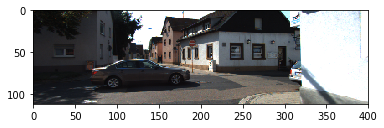

In [42]:
plt.imshow(cv.cvtColor(train_imgs[0], cv.COLOR_BGR2RGB))
plt.show()

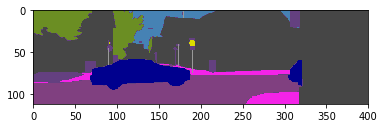

In [43]:
plt.imshow(cv.cvtColor(mask_to_img(train_masks[0], channel_to_id, id_to_label, label_to_colour), cv.COLOR_BGR2RGB))
plt.show()

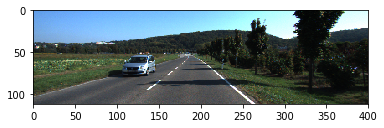

In [44]:
plt.imshow(cv.cvtColor(train_imgs[1], cv.COLOR_BGR2RGB))
plt.show()

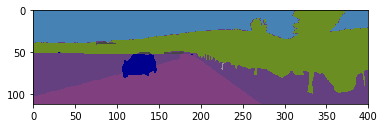

In [45]:
plt.imshow(cv.cvtColor(mask_to_img(train_masks[1], channel_to_id, id_to_label, label_to_colour), cv.COLOR_BGR2RGB))

## Network Architectures

In [46]:
def UNET(input_shape, num_outputs):
    def downsample_block(x, block_num, n_filters, pooling_on=True):

        x = Conv2D(n_filters, kernel_size=(3, 3), strides=1, padding='same', activation='relu',
                   name="Block" + str(block_num) + "_Conv1")(x)
        x = Conv2D(n_filters, kernel_size=(3, 3), strides=1, padding='same', activation='relu',
                   name="Block" + str(block_num) + "_Conv2")(x)
        skip = x

        if pooling_on is True:
            x = MaxPooling2D(pool_size=(2, 2), strides=2, padding='valid', name="Block" + str(block_num) + "_Pool1")(x)

        return x, skip

    def upsample_block(x, skip, block_num, n_filters):

        x = Conv2DTranspose(n_filters, kernel_size=(2, 2), strides=2, padding='valid',
                            name="Block" + str(block_num) + "_ConvT1")(x)
        x = concatenate([x, skip], axis=-1, name="Block" + str(block_num) + "_Concat1")
        x = Conv2D(n_filters, kernel_size=(3, 3), strides=1, padding='same', activation='relu',
                   name="Block" + str(block_num) + "_Conv1")(x)
        x = Conv2D(n_filters, kernel_size=(3, 3), strides=1, padding='same', activation='relu',
                   name="Block" + str(block_num) + "_Conv2")(x)

        return x

    input = Input(input_shape, name="Input")

    # downsampling
    x, skip1 = downsample_block(input, 1, 64)
    x, skip2 = downsample_block(x, 2, 128)
    x, skip3 = downsample_block(x, 3, 256)
    x, skip4 = downsample_block(x, 4, 512)
    x, _ = downsample_block(x, 5, 1024, pooling_on=False)

    # upsampling
    x = upsample_block(x, skip4, 6, 512)
    x = upsample_block(x, skip3, 7, 256)
    x = upsample_block(x, skip2, 8, 128)
    x = upsample_block(x, skip1, 9, 64)

    output = Conv2D(num_outputs, kernel_size=(1, 1), strides=1, padding='valid', activation='softmax', name="output")(x)

    model = Model(inputs=input, outputs=output, name="Output")

    return model

In [47]:
unet = UNET(input_shape=INPUT_SHAPE, num_outputs=num_target_ids+1)
print(unet.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input (InputLayer)              (None, 112, 400, 3)  0                                            
__________________________________________________________________________________________________
Block1_Conv1 (Conv2D)           (None, 112, 400, 64) 1792        Input[0][0]                      
__________________________________________________________________________________________________
Block1_Conv2 (Conv2D)           (None, 112, 400, 64) 36928       Block1_Conv1[0][0]               
__________________________________________________________________________________________________
Block1_Pool1 (MaxPooling2D)     (None, 56, 200, 64)  0           Block1_Conv2[0][0]               
__________________________________________________________________________________________________
Block2_Con

## Training

### Callbacks

In [48]:
def create_callbacks(wts_fn, lr_decay = 0.25, patience=5, enable_save_wts = True):

    cbks = []

    # learning rate
    lr_schedule = ReduceLROnPlateau(monitor='val_loss',
                                    factor=lr_decay,
                                    patience=patience,
                                    min_lr=1e-6,
                                    verbose=1)
    cbks.append(lr_schedule)

    # early stopping
    early_stopper = EarlyStopping(monitor='val_loss', patience=patience)
    cbks.append(early_stopper)

    # model checkpoint
    if enable_save_wts is True:
        model_chpt = ModelCheckpoint(filepath=wts_fn,
                                     monitor='val_loss',
                                     verbose=1,
                                     save_weights_only=True,
                                     save_best_only=True,
                                     period=patience)

        cbks.append(model_chpt)

    return cbks




In [49]:
def trainModel(model, model_name, n_epochs, lr, load_saved_wts=False):

    wts_fn = model_name + ".h5"

    if load_saved_wts is True:
        model.load_weights(wts_fn)

    optim = Adam(lr=lr)
    # optim = SGD(lr=lr, decay=5*1e-4, momentum=0.9)
    cbks = create_callbacks(wts_fn)
    model.compile(loss='categorical_crossentropy', optimizer=optim, metrics=['accuracy'])
    model.fit_generator(generator=train_gen,
                        validation_data=val_gen,
                        epochs=n_epochs,
                        callbacks=cbks)
    return model

In [91]:
trainModel(unet, "unet1_mc", n_epochs=10, lr=1e-6, load_saved_wts=True)

Epoch 1/10
45/45 [==============================] - 22s 484ms/step - loss: 0.3569 - acc: 0.8811 - val_loss: 0.6670 - val_acc: 0.8183
Epoch 2/10
45/45 [==============================] - 19s 418ms/step - loss: 0.3553 - acc: 0.8818 - val_loss: 0.6686 - val_acc: 0.8178
Epoch 3/10
45/45 [==============================] - 19s 419ms/step - loss: 0.3545 - acc: 0.8820 - val_loss: 0.6711 - val_acc: 0.8177
Epoch 4/10
45/45 [==============================] - 19s 420ms/step - loss: 0.3539 - acc: 0.8822 - val_loss: 0.6696 - val_acc: 0.8180
Epoch 5/10
45/45 [==============================] - 19s 420ms/step - loss: 0.3530 - acc: 0.8825 - val_loss: 0.6721 - val_acc: 0.8179

Epoch 00005: val_loss improved from inf to 0.67206, saving model to unet1_mc.h5
Epoch 6/10
45/45 [==============================] - 19s 418ms/step - loss: 0.3525 - acc: 0.8826 - val_loss: 0.6731 - val_acc: 0.8177


## Validation Set - Evaluation

In [92]:
def IOU(y_gt, y_pred, n_classes, mask_channel_to_class_id, class_id_to_label):

    iou_sum = 0
    for c in range(n_classes):
        tp = np.sum((y_gt == c) & (y_pred == c))
        fp = np.sum((y_gt != c) & (y_pred == c))
        fn = np.sum((y_gt == c) & (y_pred != c))

        iou = tp / (tp + fp + fn + 1e-8)
        iou_sum += iou

        id = mask_channel_to_class_id[c]
        print("Class: {} - Iou = {}".format(class_id_to_label[id], iou))

    mean_iou = iou_sum / n_classes
    print("Mean Iou = {}".format(mean_iou))
    
def convert_preds(model, gen, has_gt = False):
    
    n_batches = len(gen)
    y_preds = []
    y_gt = []
    
    for i, batch in enumerate(gen):

        input = batch[0]
        
        preds_masks = model.predict(x=input)
        preds_classes = np.argmax(preds_masks, axis=-1)
        y_preds.extend(preds_classes)
        
        if has_gt is True:
            output = batch[1]
            gt_classes = np.argmax(output, axis=-1)
            y_gt.extend(gt_classes)

        if i >= n_batches:
            break
    
    return np.array(y_preds), np.array(y_gt)
    

In [93]:
y_preds, y_gt = convert_preds(unet, val_gen, has_gt=True)
print(y_preds.shape)
print(y_gt.shape)

(24, 112, 400)
(24, 112, 400)


In [94]:
IOU(y_gt, y_preds, num_target_ids+1, channel_to_id, id_to_label)

Class: road - Iou = 0.8297740343077795
Class: sidewalk - Iou = 0.33089784391944493
Class: building - Iou = 0.6678034899777748
Class: pole - Iou = 0.13752880184321895
Class: traffic light - Iou = 0.041966935141831425
Class: traffic sign - Iou = 0.008913514815685586
Class: vegetation - Iou = 0.8104943910967558
Class: sky - Iou = 0.8739713299707162
Class: person - Iou = 0.0
Class: car - Iou = 0.6249249649835549
Class: truck - Iou = 0.0028409090908283834
Class: bicycle - Iou = 0.0
Class: Background - Iou = 0.5506183474310744
Mean Iou = 0.3753641971214358


In [95]:
val_batch_imgs, val_batch_masks = val_gen[0]
val_batch_preds = unet.predict(x=val_batch_imgs)

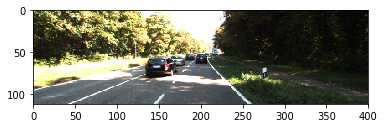

In [96]:
plt.imshow(cv.cvtColor(val_batch_imgs[2], cv.COLOR_BGR2RGB))

### Ground Truth

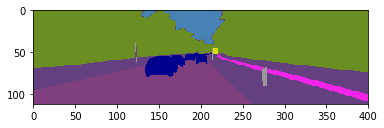

In [97]:
plt.imshow(cv.cvtColor(preds_to_img(y_gt[2], channel_to_id, id_to_label, label_to_colour), cv.COLOR_BGR2RGB))

### Prediction

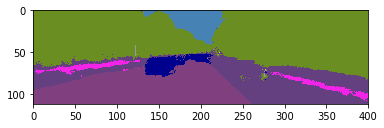

In [98]:
plt.imshow(cv.cvtColor(preds_to_img(y_preds[2], channel_to_id, id_to_label, label_to_colour), cv.COLOR_BGR2RGB))

## Test Set Evaluation

In [99]:
test_img_fns = glob.glob(os.path.join(ROOT_DIR, TEST_DIR, "*.png"))
n_test_images = len(test_img_fns)
test_img_dict = {i: test_img_fns[i] for i in range(n_test_images)}
test_idxs = np.arange(0, n_test_images)
print("# of test images: {}".format(n_test_images))


# of test images: 200


In [100]:
test_gen = MaskGenerator(test_idxs, test_img_dict, target_ids= [], img_size=INPUT_SHAPE, batch_size=4, has_masks=False)
test_batch = test_gen[0]
test_batch_preds = unet.predict_on_batch(x=test_batch)
print(test_batch_preds.shape)

(4, 112, 400, 13)


### Predictions

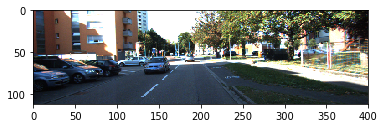

In [101]:
plt.imshow(cv.cvtColor(test_batch[0], cv.COLOR_BGR2RGB))

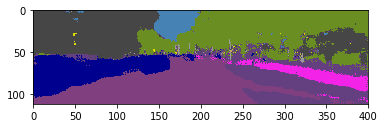

In [102]:
pred = np.argmax(test_batch_preds[0], axis=-1)
plt.imshow(cv.cvtColor(preds_to_img(pred, channel_to_id, id_to_label, label_to_colour), cv.COLOR_BGR2RGB))


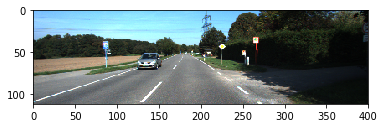

In [103]:
plt.imshow(cv.cvtColor(test_batch[1], cv.COLOR_BGR2RGB))

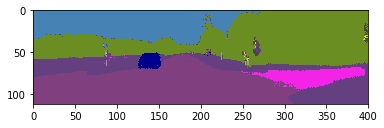

In [104]:
pred = np.argmax(test_batch_preds[1], axis=-1)
plt.imshow(cv.cvtColor(preds_to_img(pred, channel_to_id, id_to_label, label_to_colour), cv.COLOR_BGR2RGB))

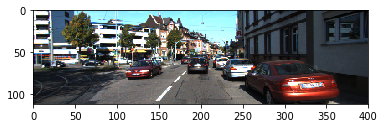

In [105]:
plt.imshow(cv.cvtColor(test_batch[2], cv.COLOR_BGR2RGB))

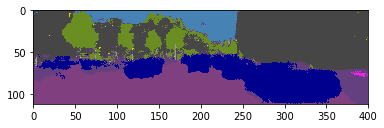

In [106]:
pred = np.argmax(test_batch_preds[2], axis=-1)
plt.imshow(cv.cvtColor(preds_to_img(pred, channel_to_id, id_to_label, label_to_colour), cv.COLOR_BGR2RGB))

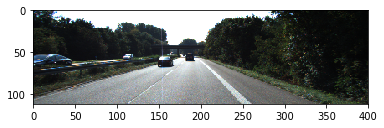

In [107]:
plt.imshow(cv.cvtColor(test_batch[3], cv.COLOR_BGR2RGB))

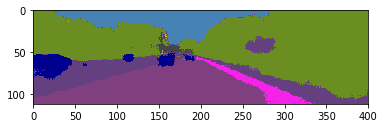

In [108]:
pred = np.argmax(test_batch_preds[3], axis=-1)
plt.imshow(cv.cvtColor(preds_to_img(pred, channel_to_id, id_to_label, label_to_colour), cv.COLOR_BGR2RGB))